# Perturbation Analysis for Parabolic Partial Differential Equations

In [1]:
import numpy as np
import scipy as sc
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from ipywidgets import interact

## Introduction

Commonly, exist some phenomena that can be represented as mathematical models, using differential equations. In some cases, simplificationes in the moment of making the model can reduce the difficulty of the representation, but in change, the model could not consider the effect of small factors that are occurring.

Parabolic Partial Differential Equations model different process in the scope of Engineering and Science. One representative Parabolic Partial Differential Equation is the following:
$$
\frac{\partial u(x,t)}{\partial t} = d\,\frac{\partial^2 u(x,t)}{\partial x^2} + c\,\frac{\partial u(x,t)}{\partial x}
$$

Tipically there are processes involved in this equation: advection, difusion and reaction. 

## Method of multiple scales

The method of multiple scales is a general method applicable in a wide range of problems. In this problems there are two processes acting at the same time, each one with its own scale. 
The problem of determinate $u(x,t)$ usually has an approximated value using the approximation:

$$
u(x,t, \varepsilon) \approx u_0(x,t) + \varepsilon \, u_1(x,t)
$$

This expansion works fine with a fixed value of $t$ and $\varepsilon$ near to zero. However, there are problems if $t \geq \mathcal{O}(\varepsilon ^{-1})$. There are two processes acting simultaneously that has its own scales. So, it is necessary to introduce two time variables:

- $\tau = t$ the _fast time_
- $T = \varepsilon t$ the _slow time_

With this variables, the solution proposed by the method has the form:

$$
u(x,t,\varepsilon) \approx u(x,\tau, T, \varepsilon)
$$

In this maner, variations of time must be deteminated in function of the variations of the _fast time_ and _slow time_. In terms of algebra:

$$
\frac{\mathrm{d}}{\mathrm{d}t} = \left( \frac{ \partial }{\partial \tau} \right) + \varepsilon \left( \frac{\partial}{\partial T} \right)
$$

Finally, the approximation for $u(x,t)$ that is asymptotic for $T = \mathcal{O}(1)$ is:

$$
u(x,t,\varepsilon) \approx u_0(x,\tau,T) + \varepsilon\, u_1(x,\tau,T)
$$

The next step is to determinate the functions $u_k$, replacing into the partial differential equation and comparing coefficients of $\varepsilon^k$ as usual.

## Application of the Method of multiple scales

### A diffusion-advection equation

Consider the following problem that shows advection around a periodic domain $0 < \theta < 2\pi$ with some small diffusion. 

\begin{align*}
\frac{\partial u(\theta,t)}{\partial t} + \frac{\partial}{\partial \theta} (\omega(\theta)\,u(\theta,t)) &= \varepsilon\frac{\partial^2u(\theta,t)}{\partial \theta^2}\\
u(\theta,0) &= F(\theta)\\
u(0,t) &= u(2\pi,t)
\end{align*}

where $\omega(\theta)$ is given over $0 \leq \theta \leq 2\pi$, periodic and positive. $F(\theta)$ is a known function and $\varepsilon$ is a tiny value.

 As can be seen there are two process acting at simultaneously: advection on the fast time scale and difusion on the slow scale. According to the method, the next expansion is used:
 
$$
u(\theta,t,\varepsilon) \approx u_0(\theta,\tau,T) + \varepsilon\, u_1(\theta,\tau,T)
$$

Sustituing into the equation and comparing coefficients there are derivated problems to solve.

**First problem**

$
\mathcal{O}(1):
$

$$
\frac{\partial u_0}{\partial \tau} + \frac{\partial}{\partial \theta}(\omega(\theta) \, u_0) = 0
$$

The first problem can be rewrited as:

$$
\frac{1}{\omega} \left( \frac{\partial}{\partial \tau} + \omega \frac{\partial}{\partial \theta}\right) (\omega\, u_0) = 0
$$

This is an advection problem that depends only of the fast time, no slow time are implicated. An observed moving at  a speed $\omega$ will see the quantity $\omega \, u_0$ remain constant. If the value of $\omega(\theta)$ was $\omega(\theta) = \omega$, where $\omega$ is constant, the solution is reduced to $u_0(\theta,\tau,T) = F(\theta-\omega\tau)$, where $F(\theta)$ is the initial value. However, in a general scenario, is necessary to know how much advanced is done after a time $\tau$. Consider the following initial value problem:

\begin{align*}
\frac{\mathrm{d}\theta}{\mathrm{d}t} &= \omega(\theta)\\
\theta(0) &= 0
\end{align*}

Supouse that $\Theta(t)$ is the solution of this problem. Then, $\theta(t)$ is a periodic function with period $P$. In order to solve the problem, a change of variable to Lagrangian coordinates $s$ and $\tau$ will be done. Let:

$$
\theta(s,\tau) = \Theta(\tau - s)
$$

Using the chain rule to recast the differential equation, the following equalities are valid:
    
\begin{align*}
\left(\frac{\partial}{\partial \tau} \right)_s &= \left( \frac{\partial}{\partial \tau}  \right)_\theta + \omega \left( \frac{\partial}{\partial \theta} \right)_{\tau}\\
\left( \frac{\partial}{\partial \theta} \right)_\tau &= -\frac{1}{\omega} \left( \frac{\partial}{\partial s} \right)_{\tau}
\end{align*}
    

Replacing into the equation, the problem is reduced to:

$$
\left(\frac{\partial}{\partial \tau} \right)_s (\omega\,u_0) = 0
$$

Which has constant solution in this coordinate system. So the value of $u_0$ can be determinated:

$$
u_0(\theta, \tau, T) = \frac{A_0(s,T)}{\omega(\theta)}
$$

This shows that an observed moving at a speed $\omega(\theta)$ will see the quantity $\omega\,u_0$ remain constant. But, this constant is allowed to modify its value in the slow scale $T$. The initial value of this _constant_ is given by the initial condition of the problem:

$$
A_0(s,0) = F(\Theta(-s))\omega(\Theta(-s))
$$


In order to deteminate $A_0$ the second problem must be aborded.

**Second Problem**

$
\mathcal{O}(\varepsilon):
$

$$
\frac{\partial u_0}{\partial T}+ \frac{\partial u_1}{\partial \tau} + \frac{\partial}{\partial \theta} (\omega(\theta) \, u_1) = \frac{\partial^2 u_0}{\partial \theta^2}
$$

Replacing the partially determined $u_0$, the problem becomes:

$$
\frac{1}{\omega} \frac{\partial A_0}{\partial T} + \frac{1}{\omega} \left(\frac{\partial}{\partial \tau}\right)_s (\omega\,u_1) = \frac{1}{\omega} \left( \frac{\partial}{\partial s} \right)_{\tau}\frac{1}{\omega} \left( \frac{\partial}{\partial s} \right)_{\tau} \frac{A_0}{\omega}
$$

with $\omega = \omega(\Theta(\tau-s))$ a $P$-periodic function of $s$ and $\tau$. Thus:

$$
\frac{\partial A_0}{\partial T} + \left(\frac{\partial}{\partial \tau}\right)_s (\omega\,u_1) = \frac{1}{\omega^2} \frac{\partial^2A_0}{\partial s^2}+ \frac{3}{2} \frac{\partial}{\partial s}\left( \frac{1}{\omega^2} \right) \frac{\partial A_0}{\partial s}+\frac{1}{2}\frac{\partial^2}{\partial s^2} \left( \frac{1}{\omega^2}\right) A_0
$$

The right side of the equation has non zero average. In order to mantain the asymptoticness of the expansion of $f$ in $T = \mathcal{O}(1)$, the quantity $\omega \,u_1$ has to be bounded as $\tau$ increases. Thus, the average with respect to $\tau$ of the right hand side must be removed by setting equal to $\displaystyle\frac{\partial A_0}{\partial T}$. The second and third terms of the right side has zero average because they are derivatives with respect to $s$ of functions of $\omega$ and so derivatives with respect to $\tau$. The next equalty must be satisfied:

$$
\frac{\partial A_0}{\partial T} = \frac{1}{P} \int_{0}^{P} \frac{1}{\omega^2(\Theta(\tau-s))} \mathrm{d}\tau \frac{\partial^2A_0}{\partial s^2}
$$

The previous equation corresponds to a Parabolic PDE with diffusion coeficient equals to the average value of $1/\omega^2$, that can be solved numerically in order to detemine $A_0$. Then, the value of $u_1$ can be obtained.

**Numerical Example**
Consider the following functions for $\omega(\theta)$ and $F(\theta)$.
\begin{align}
\omega(\theta) &= 1\\
\omega'(\theta) &= 0\\
F(\theta) &= 2\,\sin{(\theta)}
\end{align}

In [19]:
def w(theta):
    return theta**0 
def wp(theta):
    return theta*0

def F(theta):
    #return (-theta**2+2*np.pi*theta)*0.5
    return 2*np.sin(theta)

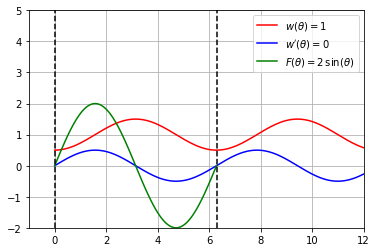

In [43]:
th = np.linspace(0,4*np.pi,200)
thh = np.linspace(0,2*np.pi,100)
W = w(th)
plt.plot(th,w(th),"-r",label=r"$w(\theta) = 1$")
plt.plot(th,wp(th),"-b",label=r"$w'(\theta) = 0$")
plt.plot(thh,F(thh),"-g",label = r"$F(\theta) = 2\,\sin{(\theta)}$")

plt.xlim(-1,12)
plt.ylim(-2,5)

plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=2*np.pi, color='k', linestyle='--')

plt.grid(True)
plt.legend(loc="best")
plt.show()

**Numerical Example 2**
Consider the following functions for $\omega(\theta)$ and $F(\theta)$.
\begin{align}
\omega(\theta) &= \sin^2{\left(\frac{\theta}{2}\right)}+\frac{1}{2}\\
\omega'(\theta) &= \frac{1}{2}\sin{(\theta)}\\
F(\theta) &= 2\,\sin{(\theta)}
\end{align}

In [33]:
def w(theta):
    return (np.sin(0.5*theta))**2+0.5

def wp(theta):
    return 0.5*np.sin(theta)
    
def F(theta):
    #return (-theta**2+2*np.pi*theta)*0.5
    return 2*np.sin(theta)

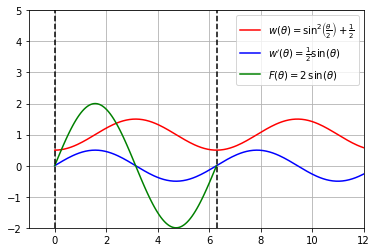

In [44]:
th = np.linspace(0,4*np.pi,200)
thh = np.linspace(0,2*np.pi,100)
W = w(th)
plt.plot(th,w(th),"-r",label=r"$w(\theta) = \sin^2{\left(\frac{\theta}{2}\right)}+\frac{1}{2}$")
plt.plot(th,wp(th),"-b",label=r"$w'(\theta) = \frac{1}{2}\sin{(\theta)}$")
plt.plot(thh,F(thh),"-g",label = r"$F(\theta) = 2\,\sin{(\theta)}$")

plt.xlim(-1,12)
plt.ylim(-2,5)

plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=2*np.pi, color='k', linestyle='--')

plt.grid(True)
plt.legend(loc="best")
plt.show()

Next, the problem is solved numerically with finite differences with an implicit method. Consider the problem in the form:

$$
\frac{\partial u(\theta,t)}{\partial t} + \frac{\partial \omega(\theta)}{\partial \theta} u(\theta,t) + \frac{\partial u(\theta,t)}{\partial \theta} \omega(\theta) = \varepsilon \frac{\partial^2 u(\theta,t)}{\partial \theta^2}
$$

The formulas of finite differences will be **backward in time** and **backward in space** for the first derivative.


In [35]:
def implicit_method(w,wp,F,N,M,eps):
    Theta = np.linspace(0,2*np.pi,N)
    T = np.linspace(0,20,M)

    dth = Theta[1]-Theta[0]
    dt = T[1]-T[0]

    A = np.zeros((N-1,N-1))
    b = np.zeros((N-1,M))

    for i in range(N-1):
        A[i,i] = 1+ wp(Theta[i])*dt + ((w(Theta[i])*dt)/dth) + 2*(eps*dt)/dth**2
        b[i,0] = F(Theta[i])
        if i==0:
            A[i,-1] = -eps*dt/dth**2  
        elif i==N-2:
            A[0,i] = -w(Theta[i])*dt/dth - eps*dt/dth**2
        if i>0:
            A[i-1,i] = -eps*dt/dth**2
        if i<N-2:    
            A[i+1,i] = -w(Theta[i])*dt/dth - eps*dt/dth**2
    #print(A)
    for j in range(M-1):
        b[:,j+1] = np.linalg.solve(A,b[:,j])
    return b

In [36]:
def simulation(i,N,M,eps=0.001):
    def w(theta):
        return theta**0
    def wp(theta):
        return theta*0

    def F(theta):
        #return (-theta**2+2*np.pi*theta)*0.5
        return 2*np.sin(theta)
    
    y1 = implicit_method(w,wp,F,N,M,0)
    y2 = implicit_method(w,wp,F,N,M,0.1)
    y3 = implicit_method(w,wp,F,N,M,0.01)
    y4 = implicit_method(w,wp,F,N,M,0.0001)
    Theta = np.linspace(0,2*np.pi,N)
    T = np.linspace(0,100,M)
    
    plt.plot(Theta[:-1],y1[:,i],"yo", label="eps=0")
    plt.plot(Theta[:-1],y2[:,i],"bo", label="eps=0.1")
    plt.plot(Theta[:-1],y3[:,i],"ro", label="eps=0.01")
    plt.plot(Theta[:-1],y3[:,i],"ro", label="eps=0.0001")
    plt.plot(Theta[:-1],y4[:,i],"ko", label="eps=0.0001")
    plt.ylim(-5,6)
    plt.grid(True)
    plt.title("t = "+str(T[i])+" [s]")
    plt.legend(loc="best")
    plt.show()
    

In [37]:
interact(simulation,i=(0,69),N=80,M=70)

<function __main__.simulation>

In [40]:
def simulation2(i,N,M,eps=0.001):
    def w(theta):
        return (np.sin(0.5*theta))**2+0.5  
    def wp(theta):
        return 0.5*np.sin(theta)

    def F(theta):
        #return (-theta**2+2*np.pi*theta)*0.5
        return 2*np.sin(theta)
    
    
    y1 = implicit_method(w,wp,F,N,M,0)
    y2 = implicit_method(w,wp,F,N,M,0.1)
    y3 = implicit_method(w,wp,F,N,M,0.01)
    y4 = implicit_method(w,wp,F,N,M,0.0001)
    Theta = np.linspace(0,2*np.pi,N)
    T = np.linspace(0,100,M)
    
    plt.plot(Theta[:-1],y1[:,i],"yo", label="eps=0")
    plt.plot(Theta[:-1],y2[:,i],"bo", label="eps=0.1")
    plt.plot(Theta[:-1],y3[:,i],"ro", label="eps=0.01")
    plt.plot(Theta[:-1],y3[:,i],"ro", label="eps=0.0001")
    plt.plot(Theta[:-1],y4[:,i],"ko", label="eps=0.0001")
    plt.ylim(-8,10)
    plt.grid(True)
    plt.title("t = "+str(T[i])+" [s]")
    plt.legend(loc="best")
    plt.show()

In [41]:
interact(simulation2,i=(0,69),N=80,M=70)

<function __main__.simulation2>